## Asset Pricing via Simulation

#### John Stachurski

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from numpy.random import randn

We aim to compute the price dividend ratio

$$
    V_t = \mathbb E_t
        \left[
            M_{t+1} \frac{D_{t+1}}{D_t}
            (1 + V_{t+1})
        \right]
$$

given the SDF and dividend process.

### Model 1

We consider the case of nonstationary dividends and consumption, where

$$ \ln \frac{D_{t+1}}{D_t} = \mu_d + X_t + \sigma_d \eta_{d, t+1} $$

The shock sequence $\{ \eta_{d,t} \}$ is IID and standard normal.  The state process $\{X_t\}$ obeys

$$ X_{t+1} = \rho X_t + \sigma \xi_{t+1} $$

where $\{ \xi_t \}$ is IID and standard normal. 

Consumption is also nonstationary, obeying

$$ \ln \frac{C_{t+1}}{C_t} = \mu_c + X_t + \sigma_c \eta_{c, t+1} $$

The sequence $\{ \eta_{c,t} \}$ is likewise IID and standard normal.

We use the Lucas SDF

$$ M_{t+1} = \beta \frac{u'(C_{t+1})}{u'(C_t)} $$

The utility function is 

$$ u(c) = \frac{c^{1-\gamma}}{1 - \gamma} $$

Hence

$$ 
    M_{t+1} 
    = \beta \left( \frac{C_{t+1}}{C_t} \right)^{-\gamma} 
    = \beta \exp(-\gamma(  \mu_c + X_t + \sigma_c \eta_{c, t+1} ))
$$

### Simulation Method

For $m$ in 1 to $M$, simulate the observation

$$ \Lambda(x, N, m) := \sum_{n=1}^N \prod_{i=1}^n A_i^{(m)} $$

where $X_0 = x$ and $m$ indicates observation $m$.

Compute

$$ \hat v(x, M, n) := \frac{1}{M} \sum_{m=1}^M \Lambda(x, N, m) $$

This is an estimate of $v(x)$


In [42]:
@jit(nopython=True)
def simulate_forward_sum_ave(x0,
                         β=0.96,
                         γ=2.0,
                         ρ=0.9,
                         σ=0.05,
                         μ_d=0.01,
                         σ_d=0.01,
                         μ_c=0.05,
                         σ_c=0.01,
                         N=1000,
                         M=20000):
    
    Λ_vals = np.empty(M)
    
    for m in range(M):
        
        # Generate the path correspoding to m
        np.random.seed(m)
        A_path = np.empty(N)
        x = x0
        for t in range(N):
            η_c = randn()
            η_d = randn()
            t1 = -γ * μ_c + μ_d + (1 - γ) * x 
            t2 = - γ * σ_c * η_c + σ_d * η_d
            A_path[t] = β * np.exp(t1 + t2)
            x = ρ * x + σ * randn()

        # Compute the forward value of that path
        A_prod = 1.0
        Λ = 0.0
        for n in range(N):
            A_prod *= A_path[n]
            Λ += A_prod
    
        # Record the result, adding it to the sum
        Λ_vals[m] = Λ
            
    return Λ_vals.mean()
        

In [43]:
@jit(nopython=True, parallel=True)
def compute_prices_across_states(x_vals):
    n = len(x_vals)
    v_vals = np.empty(n)
    for i in prange(n):
        v_vals[i] = simulate_forward_sum_ave(x_vals[i])
    return v_vals

In [44]:
x_vals = np.linspace(-0.3, 0.3, 20)

In [45]:
v_vals = compute_prices_across_states(x_vals)

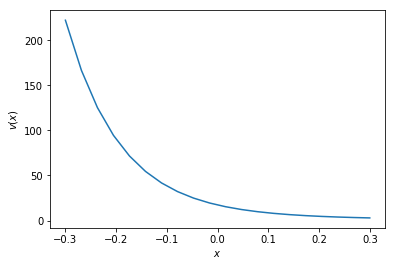

In [46]:
fig, ax = plt.subplots()
ax.plot(x_vals, v_vals)
ax.set_xlabel("$x$")
ax.set_ylabel("$v(x)$")
plt.show()

### Model 2

Following Song, Schorfheide and Yaron (2018, ECMA), let


\begin{align*}
    \ln \frac{C_{t+1}}{ C_t} &
    = \mu_c + z_t + \sigma_{c, t} \, \eta_{c, t+1},
    \\
    \ln \frac{D_{t+1}}{ D_t} &
    = \mu_d + \alpha z_t + \delta \sigma_{c, t} 
        \, \eta_{c, t+1} + \sigma_{d, t} \, \eta_{d, t+1}
\end{align*}

where

\begin{align*}
    z_{t+1} & = \rho \, z_t + (1 - \rho^2)^{1/2} \, 
        \sigma_{z, t} \, \upsilon_{t+1},
    \\
    \sigma_{i, t} & = \varphi_i \, \bar{\sigma} \exp(h_{i, t}),
    \\
    h_{i, t+1} & = \rho_{h_i} h_i + \sigma_{h_i} \xi_{i, t+1},
    \quad i \in \{z, c, d\}
\end{align*}


As before,

$$
    A_{t+1} 
    = M_{t+1} \frac{D_{t+1}}{D_t} 
    = \beta \left( \frac{C_{t+1}}{C_t} \right)^{-\gamma} 
        \frac{D_{t+1}}{D_t}
$$

This becomes

$$
    A_{t+1} 
    =  \beta \exp(
        -\gamma  \mu_c + \mu_d
        + (\alpha - \gamma) z_t 
        - \gamma  \sigma_{c, t} \eta_{c, t+1} 
        + \sigma_{d, t} \eta_{d, t+1}
        )
$$